# X-Ray Binary Classification

This project is used for generating x-ray binary classifications. 
The dataset is coming from X-Ray Chest Images by Tolga
More detail about dataset: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

The objective about this project is building based model from CNN about image classifications that classifying an image has pneumonia or not.

Talking about pneumonia, you can read more detail about this on this article:
https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204 

FYI:
After train this dataset, the model has an overfitting problem.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import os
import zipfile
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import models, layers

# Importing Dataset

Download and unzip the datasets

In [2]:
# Alternatif Download from Github -> WIP
# data = requests.get("")

Extract data into data path

In [3]:
extracted_data_path = 'data/'
zip_path = 'data/archive.zip'

with zipfile.ZipFile(zip_path, 'r') as zipfile:
    zipfile.extractall(extracted_data_path)

print(f"Data was extracted into {extracted_data_path} path") 

Data was extracted into data/ path


Finding the directory informations

In [4]:
dataset_path = 'data/chest_xray'

for dirpath, _, filenames in os.walk(dataset_path):
    folder_name = os.path.basename(dirpath)
    file_count = len([f for f in filenames if not f.startswith(".")]) 
    print(f"Folder: {folder_name}, Banyaknya berkas: {file_count}")

Folder: chest_xray, Banyaknya berkas: 0
Folder: test, Banyaknya berkas: 0
Folder: PNEUMONIA, Banyaknya berkas: 390
Folder: NORMAL, Banyaknya berkas: 234
Folder: train, Banyaknya berkas: 0
Folder: PNEUMONIA, Banyaknya berkas: 3883
Folder: NORMAL, Banyaknya berkas: 1349


## Problem - Imbalenced datasets

In the directory informations, we found that data training with NORMAL labels has smaller than pneumonia. 
This means, the training has imbalanced datasets. 

This problems need to be solved because we are facing the health issues. 
The models need to classify the minority class, which means the models need to good for classifying the NORMAL cases.

**The impact is big if it's wrong**

We are going to implement simple data augmentations with focusing on data rotations around 10 degrees.

### Minority IDG

In [5]:
# Seperate the data based on labels -> only choose Normal (this is the minority)
minority_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)

In [6]:
normal_dir = './data/chest_xray/train/NORMAL'
aug_dir = './data/chest_xray/train/NORMAL_augmented'
os.makedirs(aug_dir,exist_ok=True)

In [7]:
images = os.listdir(normal_dir)
target_total = len(images) * 2 #Stopper bcs the objective is multiply the dataset.
generated = 0

for img_name in images:
    img_path = os.path.join(normal_dir, img_name)
    img = load_img(img_path, target_size=[150,150])
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape) # dibutuhkan karena kebutuhan .flow nanti formatnya (1,150,150,3)
    
    for batch in minority_aug.flow(img_array, batch_size=1, save_to_dir=aug_dir, save_prefix='aug', save_format='jpeg'):
        generated += 1
        if generated >= target_total:
            break
    if generated >= target_total:
        break

### Gabungkan dataset yang sudah augmented dengan direktori asli.

In [8]:
for fname in os.listdir(aug_dir):
    shutil.move(os.path.join(aug_dir, fname), os.path.join(normal_dir, fname))

print(f"Sebanyak {len(os.listdir(normal_dir))} data ditemukan pada berkas {normal_dir}")

Sebanyak 3704 data ditemukan pada berkas ./data/chest_xray/train/NORMAL


In [9]:
shutil.rmtree(aug_dir)

# Training

## Build ImageDataGenerator

In [10]:
# Tanpa augmentasi biar ga over.
train_datagen = ImageDataGenerator(
    rescale= 1/.255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/.255,
)

## Build Generator for training & Validation

In [11]:
train_dir = './data/chest_xray/train'
test_dir = './data/chest_xray/test'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    class_mode='binary',
    target_size=[150,150],
    batch_size=32,
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=[150,150],
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=[150,150],
    batch_size=32,
    class_mode='binary',
    shuffle=False # because important to evaluate.
)

Found 6071 images belonging to 2 classes.
Found 1516 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Membangun Arsitektur

In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=[150,150,3]),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/dicoding/Dicoding/github/mlops/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Callbacks functions

class myCallBacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('loss') < 0.9):
            self.model.stop_training = True

In [15]:
CALLBACKS = myCallBacks()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[CALLBACKS]
)

Epoch 1/20


/Users/dicoding/Dicoding/github/mlops/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


190/190 ━━━━━━━━━━━━━━━━━━━━ 35s 182ms/step - accuracy: 0.7717 - loss: 388.2588 - val_accuracy: 0.8747 - val_loss: 0.4454
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step - accuracy: 0.9550 - loss: 0.1499 - val_accuracy: 0.8582 - val_loss: 0.4541


In [16]:
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc: .4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.6109 - loss: 1.6261
Test accuracy:  0.7837


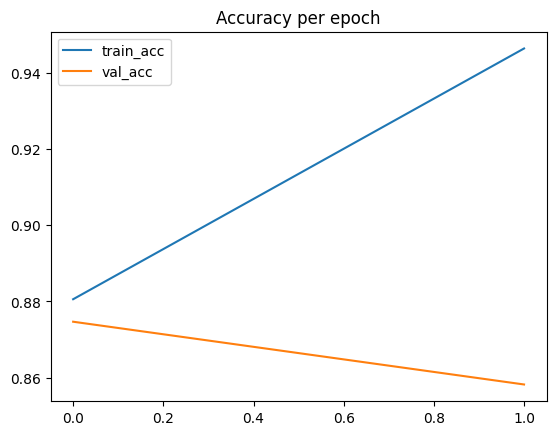

In [19]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

# Export Model to SavedModel

In [28]:
!mkdir -p ./models/
model.export("./models")

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Saved artifact at './models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  6061870592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061393696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061453904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061453728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061455840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061455664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061457248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6061474032: TensorSpec(shape=(), dtype=tf.resource, name=None)
